Using the CNN in InceptionV3 to make image more fantastic

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib as mpl

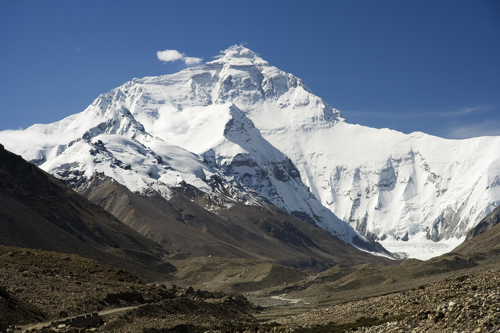

In [10]:
import IPython.display as display
import PIL.Image

import requests
url = "https://upload.wikimedia.org/wikipedia/commons/e/e7/Everest_North_Face_toward_Base_Camp_Tibet_Luca_Galuzzi_2006.jpg"
img_path = "mountain.jpg"
req = requests.get(url, stream=True)
with open(img_path, "wb") as f:
  for chunk in req.iter_content():
    f.write(chunk)

img = PIL.Image.open(img_path)
img = img.resize((500,333))
img

In [11]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 [==============================] - 1s 0us/step


In [14]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

In [13]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

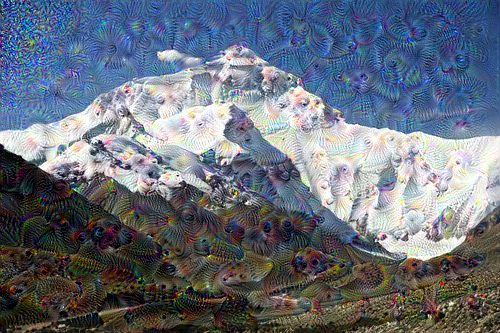

In [39]:
step = 100
step_size=0.01
img_np = np.array(img)
img_np = tf.keras.applications.inception_v3.preprocess_input(img_np)
img_np = tf.convert_to_tensor(img_np)

def cal_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

for i in range(step):
  with tf.GradientTape() as tape:
    tape.watch(img_np)
    loss = cal_loss(img_np, dream_model)
  gradients = tape.gradient(loss, img_np)
  gradients /= tf.math.reduce_std(gradients) + 1e-8
  img_np = img_np + gradients*step_size
  img_np = tf.clip_by_value(img_np, -1, 1)

result = deprocess(img_np.numpy())
PIL.Image.fromarray(np.array(result))